## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
group_one = dataset[dataset["Diagnosis"] == 0]
group_two = dataset[dataset["Diagnosis"] == 2]

combined_group_one = pd.concat([group_one, group_two], ignore_index = True)
combined_group_one["Diagnosis"].unique()

array([0, 2])

In [4]:
combined_group_one

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
1,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
2,14,1,78.6137,0,29.0,0.12,188.33,0.49,183.76,39.63,...,241.64,0.44,226.48,35.11,664.29,3.10,8478.33,3.01,1809.0,3292.0
3,15,0,80.9068,0,29.0,0.10,161.28,0.54,174.53,35.94,...,221.76,0.45,NaN,30.57,NaN,3.12,4287.78,2.90,2188.0,3603.0
4,16,0,65.5205,0,28.0,0.12,166.97,0.58,202.96,38.42,...,228.53,0.50,228.72,28.98,686.36,2.90,-1381.99,2.73,1829.0,3695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,549,0,68.8849,2,25.0,0.11,169.76,0.58,205.91,38.90,...,219.32,0.53,229.07,30.38,696.95,3.05,1.54,3.53,2140.0,3801.0
274,658,0,72.2822,2,30.0,0.13,187.66,0.57,222.54,37.58,...,206.16,0.55,227.90,30.10,705.46,3.03,281.47,NaN,2750.0,3345.0
275,1244,0,79.0877,2,24.0,0.13,152.52,0.63,208.54,35.72,...,220.67,0.53,231.71,30.18,706.18,3.02,28.95,2.98,2016.0,3532.0
276,1311,0,69.2110,2,29.0,0.10,175.27,0.50,187.40,44.04,...,222.69,0.52,229.54,32.03,695.47,3.05,2811.38,2.98,1605.0,3219.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_group_one.drop("Diagnosis", axis=1),  
    combined_group_one["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((194, 23), (84, 23))

In [6]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [8]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [9]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((194, 23), (84, 23))

In [10]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr', threshold=0.0005)

In [11]:
# select features
X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_train_t.shape, X_test_t.shape

((194, 15), (84, 15))

## TPE

In [12]:
from sklearn.preprocessing import LabelEncoder

# 1) Fit a label encoder on the training labels:
le_train = LabelEncoder().fit(y_train)
le_test = LabelEncoder().fit(y_test)

# 2) Transform y_train (and later y_test) to {0,1} internally:
y_train_enc = le_train.transform(y_train)
y_test_enc = le_test.transform(y_test)

In [13]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
    
    ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 100, 500)
    ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.01, 0.1, log=True)    
    model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train_enc))),
                              n_estimators=ngb_n_estimators,
                              learning_rate=ngb_learning_rate,
                              verbose=False) 

    score = cross_val_score(model, X_train_t, y_train_enc, scoring="accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [14]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-05-13 16:36:48,496] A new study created in memory with name: no-name-93b5ce9a-157f-4ca1-803a-12773ac5578a
[I 2025-05-13 16:36:59,507] Trial 0 finished with value: 0.876578947368421 and parameters: {'ngb_n_estimators': 244, 'ngb_learning_rate': 0.015114209376554643}. Best is trial 0 with value: 0.876578947368421.
[I 2025-05-13 16:37:24,058] Trial 1 finished with value: 0.8768421052631579 and parameters: {'ngb_n_estimators': 497, 'ngb_learning_rate': 0.03303623700755305}. Best is trial 1 with value: 0.8768421052631579.
[I 2025-05-13 16:37:39,246] Trial 2 finished with value: 0.8818421052631578 and parameters: {'ngb_n_estimators': 304, 'ngb_learning_rate': 0.03544292000284334}. Best is trial 2 with value: 0.8818421052631578.
[I 2025-05-13 16:37:54,160] Trial 3 finished with value: 0.8926315789473686 and parameters: {'ngb_n_estimators': 195, 'ngb_learning_rate': 0.06671965286820386}. Best is trial 3 with value: 0.8926315789473686.
[I 2025-05-13 16:38:50,643] Trial 4 finished with v

In [15]:
study.best_params

{'ngb_n_estimators': 195, 'ngb_learning_rate': 0.06671965286820386}

In [16]:
study.best_value

0.8926315789473686

In [17]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_ngb_learning_rate,params_ngb_n_estimators,state
0,0,0.876579,2025-05-13 16:36:48.498843,2025-05-13 16:36:59.507106,0 days 00:00:11.008263,0.015114,244,COMPLETE
1,1,0.876842,2025-05-13 16:36:59.508072,2025-05-13 16:37:24.058225,0 days 00:00:24.550153,0.033036,497,COMPLETE
2,2,0.881842,2025-05-13 16:37:24.059227,2025-05-13 16:37:39.246966,0 days 00:00:15.187739,0.035443,304,COMPLETE
3,3,0.892632,2025-05-13 16:37:39.247933,2025-05-13 16:37:54.160173,0 days 00:00:14.912240,0.066720,195,COMPLETE
4,4,0.887105,2025-05-13 16:37:54.177408,2025-05-13 16:38:50.643379,0 days 00:00:56.465971,0.036283,498,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_13656\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


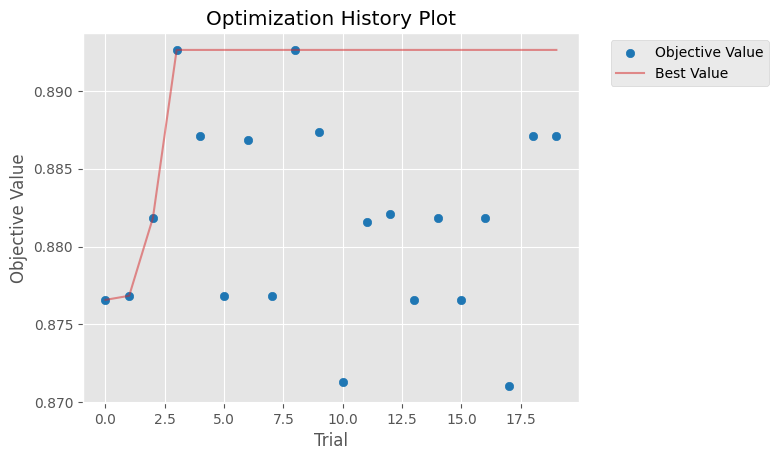

In [18]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_13656\3449611284.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='ngb_learning_rate', ylabel='Objective Value'>,
       <Axes: xlabel='ngb_n_estimators'>], dtype=object)

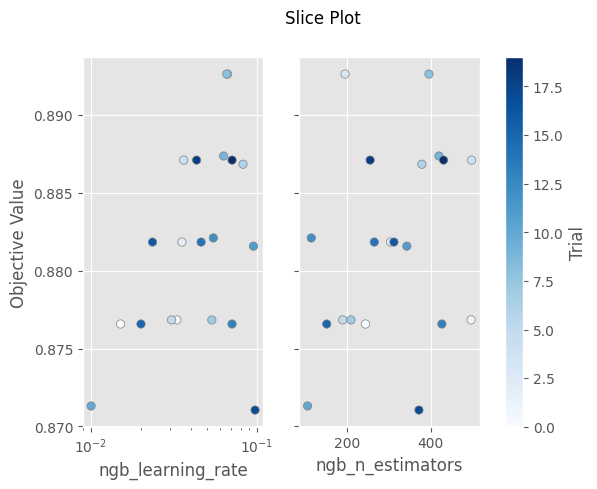

In [19]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["ngb_n_estimators", "ngb_learning_rate"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_13656\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

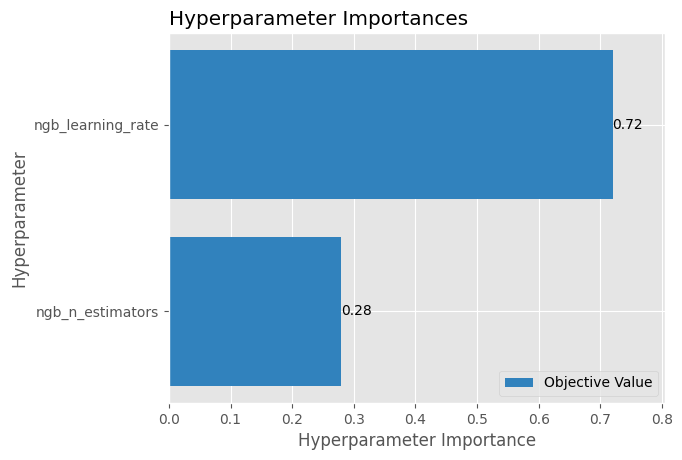

In [20]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_13656\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

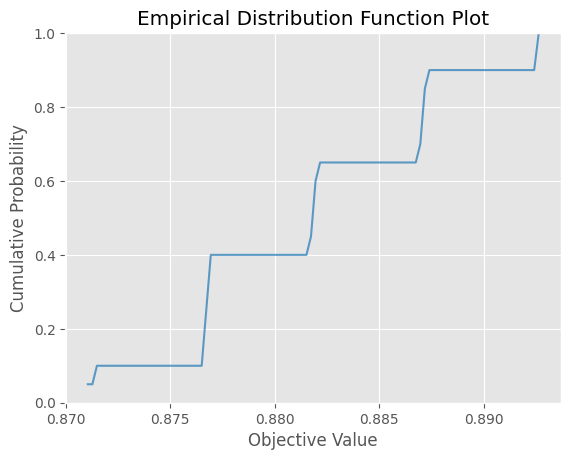

In [21]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [22]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                        n_estimators=study.best_params['ngb_n_estimators'],
                        learning_rate=study.best_params['ngb_learning_rate'], 
                        random_state=42
        )

        if sel_method == "RFE":
                sel_method = "RFE" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [23]:
trained_ngb_n, metrics_ngb_n = run_model("NGBoost", "Complete", X_train_knn_t, y_train_enc)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", "RFE", X_train_t, y_train_enc)

[iter 0] loss=0.6049 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0585 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6049 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0510 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6049 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0722 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6049 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0620 val_loss=0.0000 scale=0.0005 norm=0.0005
[iter 0] loss=0.6084 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.0704 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6084 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0629 val_loss=0.0000 scale=0.0156 norm=0.0174
[iter 0] loss=0.6084 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.0609 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6034 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0611 val_loss=0.0000 scale=0.000

In [24]:
validation_df = pd.concat([metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
NGBoost    balanced_accuracy Complete          1.193    23                   0.950   
                             RFE               1.167    15                   0.952   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          1.193    23                  0.011   
                             RFE               1.167    15                  0.009   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          1.193    23                  0.853   
                             RFE               1.167    15                  0.836   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
NGBoost    balanced_accuracy Complete          1.193    23                 0.081  
                             RFE               1.167    15                 0.103

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train), 3),
                "recall": round(recall_score(y_train, pred_train), 3),
                "f1": round(f1_score(y_train, pred_train), 3),
                "roc_auc_ovr": round(roc_auc_score(y_train, pred_train_proba[:, 1]),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test), 3),
                "recall": round(recall_score(y_test, pred_test), 3),
                "f1": round(f1_score(y_test, pred_test), 3),
                "roc_auc_ovr": round(roc_auc_score(y_test, pred_test_proba[:, 1]), 3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train_enc, y_test_enc)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Boruta            NGBoost    0.267               23             accuracy                0.974   
                                                                balanced_accuracy       0.956   
                                                                precision               1.000   
                                                                recall                  0.912   
                                                                f1                      0.954   
                                                                roc_auc_ovr             0.999   
                             0.250               15             accuracy                0.969   
                                                                balanced_accuracy       0.947   
                                                                precision               1.000   
                                                                recall                  0.895   
                                                                f1                      0.944   
                                                                roc_auc_ovr             1.000   

                                                                                   Test data  
Feature Selection Classifier Classification Time Total Features Metric                        
Boruta            NGBoost    0.267               23             accuracy               0.869  
                                                                balanced_accuracy      0.826  
                                                                precision              0.864  
                                                                recall                 0.704  
                                                                f1                     0.776  
                                                                roc_auc_ovr            0.924  
                             0.250               15             accuracy               0.881  
                                                                balanced_accuracy      0.844  
                                                                precision              0.870  
                                                                recall                 0.741  
                                                                f1                     0.800  
                                                                roc_auc_ovr            0.939

### Export model

In [27]:
trained_ngb_t

NGBClassifier(learning_rate=0.06671965286820386, n_estimators=195,
              random_state=RandomState(MT19937) at 0x26789D3B440)

In [28]:
import pickle

# Save the trained model using pickle
with open("ngboost_model_group_one.pkl", "wb") as file:
    pickle.dump(trained_ngb_t, file)

print("NGBoost model saved successfully!")

NGBoost model saved successfully!


In [29]:
# Load the saved model using pickle
with open("ngboost_model_group_one.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)